dict_keys(['description', 'driverShortName', 'driverLongName', 'files', 'size', 'coordinateSystem', 'geoTransform', 'metadata', 'cornerCoordinates', 'wgs84Extent', 'bands', 'stac'])
[12.50387, 1.54263877715e-05, 0.0, 55.80383, 0.0, -1.54223652454e-05]
{'upperLeft': [12.50387, 55.80383], 'lowerLeft': [12.50387, 55.76549], 'lowerRight': [12.54222, 55.76549], 'upperRight': [12.54222, 55.80383], 'center': [12.523045, 55.78466]}
55.80383 12.50387


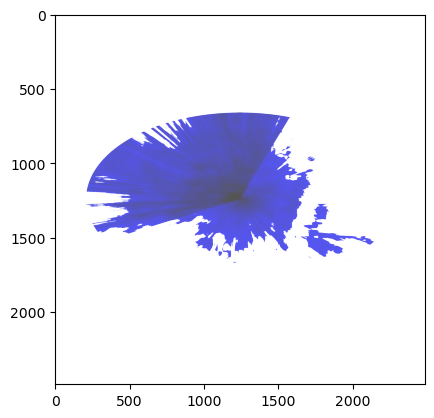

In [157]:
from osgeo import gdal
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ds = gdal.Open('cloudRF_tiff/0522224354_My_Network_Site.4326.tiff', gdal.GA_ReadOnly)
ds = gdal.Open('cloudRF_tiff/0522224354_My_Network_Site.4326.tiff', gdal.GA_ReadOnly)
tiff_dict = gdal.Info(ds, options=gdal.InfoOptions(format='json'))
print(tiff_dict.keys())
print(tiff_dict['geoTransform'])
print(tiff_dict['cornerCoordinates'])
lat_per_pixel, long_per_pixel = abs(float(tiff_dict['geoTransform'][-1])), \
                                abs(float(tiff_dict['geoTransform'][1]))
lat_TL, long_TL = tiff_dict['cornerCoordinates']['upperLeft'][::-1]
print(lat_TL, long_TL)

tiff_img = Image.open('cloudRF_tiff/0522224354_My_Network_Site.4326.tiff')
tiff_img = np.asarray(tiff_img)
plt.imshow(tiff_img)
for ii in range(len(tiff_img)):
    if tiff_img[1, ii][2] != 255:
        print(ii)

In [137]:
import csv

reader_out = csv.reader(open('../raw_data/output_matrix.csv', 'r'), delimiter=',')
next(reader_out)

reader_in = csv.reader(open('../raw_data/feature_matrix.csv', 'r'), delimiter=',')
next(reader_in)

lat_arr_actual, long_arr_actual, ss_arr_actual = [], [], []
for row_out, row_in in zip(reader_out, reader_in):
    if int(row_in[-2]) == 1:  # only taking data points from one antenna
        ss_arr_actual.append(float(row_out[-1]))
        lat_arr_actual.append(float(row_in[2]))
        long_arr_actual.append(float(row_in[1]))
# output_matrix.csv has each row organised as: ,SINR,RSRP,RSRQ,Power
# feature_matrix: ,Longitude,Latitude,Speed,Distance,Distance_x,Distance_y,PCI,PCI_64,PCI_65,PCI_302

col_names1 = ['LATITUDE', 'LONGITUDE', 'VALUE']
df_actual_data = pd.DataFrame(list(zip(lat_arr_actual, long_arr_actual, ss_arr_actual)),
                              columns=col_names1)
len(df_actual_data['LATITUDE'])

22107

In [144]:
"""
    loc_to_pow finds the power at the pixel specified by lat, long. lat_TL, long_TL are the top-left lat and long values of the tiff file. lat_per_pixel_ is found using gdal. factor is the scale factor going from img_arr[r, c, 2] to power (ss). +40 is a constant offset.
"""
def loc_to_pow(img_arr, lat, long, lat_TL_=lat_TL, long_TL_=long_TL, lat_per_pixel_=lat_per_pixel,
               long_per_pixel_=long_per_pixel, factor=184/55, ret_rc='n'):
    d_lat, d_long = lat - lat_TL_, long - long_TL_
    r, c = abs(round(d_lat / lat_per_pixel_)), round(d_long / long_per_pixel_)
    if ret_rc == 'y':
        return -(abs((img_arr[r, c, 2]) / 1 / factor) + 40), r, c
    return -(abs((img_arr[r, c, 2]) / 1 / factor) + 40)

# fac = np.linspace(2.8, 4, 33333)
diff_arr = []
fac = [3, 184/55]
for i in fac:
    # print(i)
    a = loc_to_pow(img_arr=tiff_img, lat=55.786509, long=12.518564, lat_TL_=lat_TL,
                   long_TL_=long_TL, lat_per_pixel_=lat_per_pixel, long_per_pixel_=long_per_pixel,
                   factor=i) + 69
    b = loc_to_pow(img_arr=tiff_img, lat=55.788995, long=12.514248, lat_TL_=lat_TL,
                   long_TL_=long_TL, lat_per_pixel_=lat_per_pixel, long_per_pixel_=long_per_pixel,
                   factor=i) + 93
    c = loc_to_pow(img_arr=tiff_img, lat=55.792444, long=12.523458, lat_TL_=lat_TL,
                   long_TL_=long_TL, lat_per_pixel_=lat_per_pixel, long_per_pixel_=long_per_pixel,
                   factor=i) + 95
    print(abs(a) + abs(b) + abs(c))
    print(a, b, c)
    diff_arr.append(np.sqrt(abs(a)**2 + abs(b)**2 + abs(c)**2))

print(fac[np.argmin(diff_arr)])

# plt.plot(fac, diff_arr)

16.333333333333343
-4.0 -6.0 -6.333333333333343
0.6847826086956417
-0.5923913043478279 0.09239130434781373 0.0
3.3454545454545452


24.071960653410184
minimum rmse is: 11.14452289521865 it occurs at offset: -21.5


Text(0, 0.5, 'RMSE')

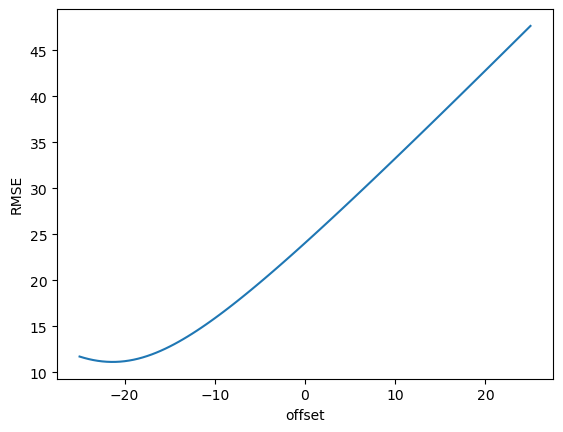

In [170]:
def RMSE_cloudRF_and_empirical_ss(img_arr, offset=-18, df_actual_values=df_actual_data):
    sum_squares = []
    idx = 0
    for lat, long, ss_empirical in zip(df_actual_values['LATITUDE'], df_actual_values['LONGITUDE'], df_actual_values['VALUE']):
        ss_cloudRF, rr, cc = loc_to_pow(img_arr=img_arr, lat=lat, long=long, factor=184/55, ret_rc='y')
        if img_arr[rr, cc, 2] != 255:
            ss_corrected = ss_empirical + offset
            sum_squares.append((ss_cloudRF - ss_corrected) ** 2)
        idx += 1
    return np.sqrt(np.average(sum_squares))

offset_arr = np.linspace(-25, 25, num=101)
rmse_arr = np.zeros(len(offset_arr))
print(RMSE_cloudRF_and_empirical_ss(tiff_img, offset=0))
for j, off in enumerate(offset_arr):
    rmse_arr[j] = RMSE_cloudRF_and_empirical_ss(tiff_img, offset=off)

# print(offset_arr[np.argmin(rmse_arr)])
print('minimum rmse is:', min(rmse_arr), 'it occurs at offset:', offset_arr[np.argmin(rmse_arr)])
plt.plot(offset_arr, rmse_arr)
plt.xlabel('offset')
plt.ylabel('RMSE')

In [167]:
def loc_of_largest_diff(img_arr, offset=0, df_actual_values=df_actual_data):
    difference_arr = np.zeros(len(df_actual_values['VALUE']))
    idx = 0
    for lat, long, ss_empirical in zip(df_actual_values['LATITUDE'], df_actual_values['LONGITUDE'], df_actual_values['VALUE']):
        ss_cloudRF, rr, cc = loc_to_pow(img_arr=img_arr, lat=lat, long=long, factor=184/55, ret_rc='y')
        if img_arr[rr, cc, 2] != 255:
            ss_corrected = ss_empirical + offset
            difference_arr[idx] = (ss_cloudRF - ss_corrected) ** 2
        idx += 1
    max_diff_idx = np.argmax(difference_arr)
    return df_actual_values['LATITUDE'][max_diff_idx], df_actual_values['LONGITUDE'][max_diff_idx]

lat_temp, long_temp = loc_of_largest_diff(img_arr=tiff_img, offset=0,
                                          df_actual_values=df_actual_data)

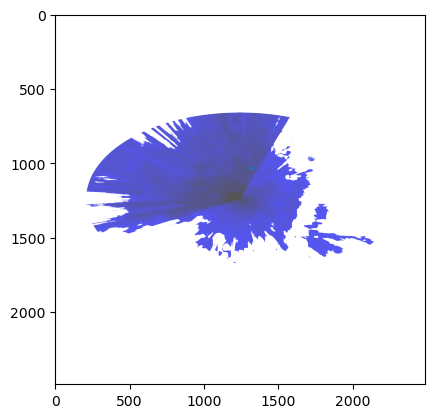

In [168]:
plt.imshow(tiff_img)
_, tempr, tempc = loc_to_pow(img_arr=tiff_img, lat=lat_temp, long=long_temp, ret_rc='y')
plt.scatter(tempr, tempc, s=3)
